# EE353 ASSIGNMENT 3
#### PRIYANSH SINGH
#### 22b1856
#### LINK TO THE EXPLANATORY VIDEO: 

In [2]:
#data handling and basic math libraries
import pandas as pd #pandas for csv file reading and dataframe handling
import numpy as np #numpy for basic matrix computations
import sklearn as sk

#time library for complexity analysis
import time 

#plotting libraries
import matplotlib.pyplot as plt #for scatter and line plots of arrays
import seaborn as sns #for heatmaps

# Objective 1

### Reading the dataset file

In [3]:
data = pd.read_csv('bank.csv') #using oandas read csv to read the csv file

## Task 1 - EDA

### Data description [1]

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (column deposit in the dataset).

### Usable variables

### Looking at the dataset, the following columns can be deemed useless for the current task in hand: [1]
- $\textbf{Contact}$: Contact communication type - useless for identifying the effectiveness of the marketing campaign, is either of the type cellular or telephone, so it won't affect the outcome to a large extent
- $\textbf{Day}$: Last contact day of the year 
- $\textbf{Month}$: Last contact minth of the year  
- $\textbf{Duration}$ - This is the duration in seconds for which the call lasted, and since this information is not present before the call began, we can't use this in our predictive model as we will be unable ot make any inference before the call itself. [1]
- $\textbf{Campaign}$: For a similar reason as above, the number of calls for the current campaign is useless for inference and for prediction.

In [4]:
filtered_data = data.drop(['contact', 'day', 'month', 'duration', 'campaign'], axis = 1) #removing the useless columns as discussed above

### Data cleaning 
- After a thorough search for missing/NaN values in the dataset, the only missing cells were the ones filled with "unknown", apart from which the data was completely clean

### Correlations among the variables

- A correlation heatmap can be plotted for the columns of the data, for which all columns have to be encoded into numerical values

In [34]:
#[3]
filtered_data_num = filtered_data.copy() # copying the filtered dataframe into a dataframe which will be numerically encoded 

### Using One-hot encoding for all the non-binary categorical columns

In [35]:
#One-hot encoding for the columns: Job, Marital, Education, poutcome
#[4]
filtered_data_num = pd.get_dummies(filtered_data_num, columns = ['job', 'marital', 'education', 'poutcome']) #using the get_dummies function in pandas
filtered_data_num = filtered_data_num.drop(['job_unknown', 'education_unknown', 'poutcome_unknown'], axis = 1) #removing the one hot columns corresponding to unknown entries

In [36]:
print("Column Names:") #printing the column names
print("\n".join(filtered_data_num.columns)) #all columns od the filtered dataframe

Column Names:
age
default
balance
housing
loan
pdays
previous
deposit
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
marital_divorced
marital_married
marital_single
education_primary
education_secondary
education_tertiary
poutcome_failure
poutcome_other
poutcome_success


### Binary encoding for the binary columns
- default
- housing
- loan


In [41]:
filtered_data_num[['default', 'housing', 'loan']] = filtered_data_num[['default', 'housing', 'loan']].replace({'no': 0, 'yes': 1}) #encoding the yes as 1 and no as 0, "unknown" remaining "unknown"
filtered_data_num_X = filtered_data_num.drop(['deposit'], axis = 1) #Dataframe of the independent variables

### Iteratively finding correlations between the columns
- NOTE: I am not using the filtered_data_num.corr() function due to the various columns containing "unknown" in multiple different rows, which would need removal of all such rows, significantly reducing the data size.

In [45]:
#[5]
corr_matrix = pd.DataFrame(np.nan, index=filtered_data_num_X.columns, columns=filtered_data_num_X.columns) #creating a column name indiced square matrix dataframe to hold the correlation values 
for col1 in filtered_data_num_X.columns: #looping once through all the columns
    for col2 in filtered_data_num_X: #second loop

        column1 = filtered_data_num_X[col1] #reading the col1 of filtered data
        column2 = filtered_data_num_X[col2] #reading the col2 of filtered data

        for i in column1.index[column1 == 'unknown']: #checking for unknown entries in col1
            column1.drop(i).reset_index(drop = True) #[6] dropping and resetting the rows with unknown entries 
            column2.drop(i).reset_index(drop = True) #dropping and resetting the rows with unknown entries for col2

        for i in column2.index[column2 == 'unknown']: #checking for unknown entries in col1
            column1.drop(i).reset_index(drop = True) #[6] dropping and resetting the rows with unknown entries 
            column2.drop(i).reset_index(drop = True) #dropping and resetting the rows with unknown entries for col2

        corr_matrix.at[col1, col2] = column1.corr(column2) #Correlation between col1 and col

C:\Users\Admin\AppData\Local\Temp\ipykernel_684\3846106936.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(corr_matrix, annot=corr_matrix.applymap(lambda x: 'X' if abs(x) > 0.6 else ''), fmt='', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}) #annotated heatmap


Text(0.5, 1.0, 'Correlation heatmap for the dataset')

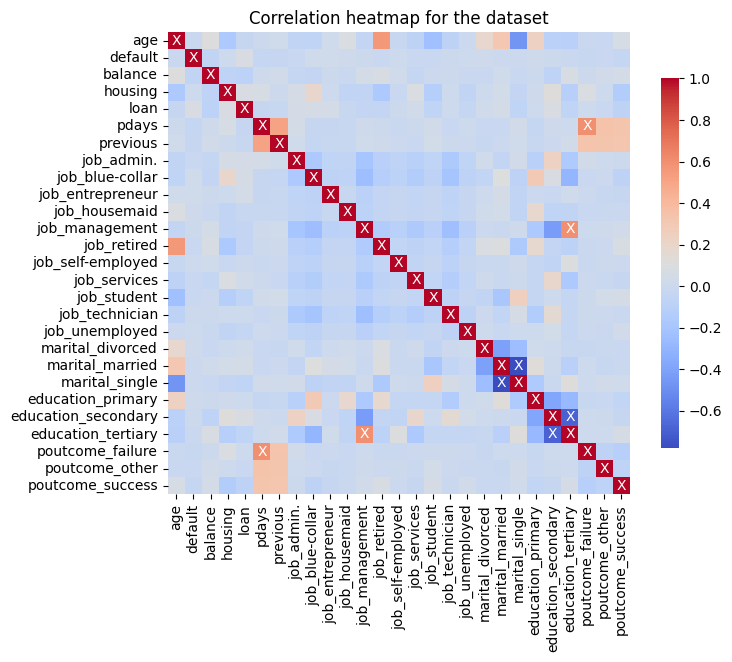

In [59]:
plt.figure(figsize = (8, 6)) #setting output figure size 
#[7]
sns.heatmap(corr_matrix, annot=corr_matrix.applymap(lambda x: 'X' if abs(x) > 0.6 else ''), fmt='', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}) #annotated heatmap
plt.title("Correlation heatmap for the dataset") #title for the heatmap

### Decision from the dcorrelation heatmap:
- Due to high correlation between the job_retired column and the age column (which is logically expected), we can drop the job_retired column
- Apart from this pair, other correlated columns don't seem logical to be dropped

In [60]:
filtered_data_num = filtered_data_num.drop(['job_retired'], axis = 1) #dropping the job_retired one-hot column

### Checking for balance in the output class

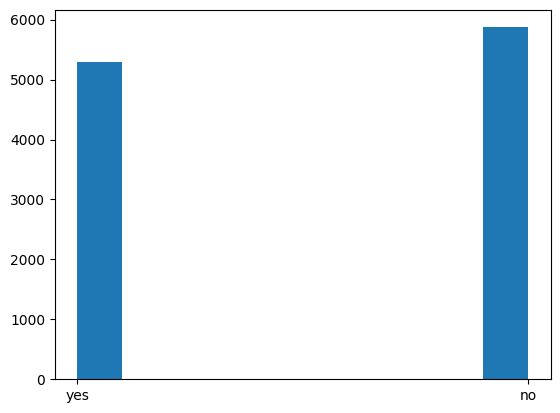

In [76]:
plt.hist(filtered_data_num['deposit']) #plotting a histogram of the deposit column
plt.show() #show the plot

- The above histogram suggests a pretty much balanced class column   

### Which classes to use
- This question has been answered while doing one-hot encoding and removing the job_retired column

# References:  
[1]: Description of the dataset from the UCI ML repository website: https://archive.ics.uci.edu/dataset/222/bank+marketing  
[2]: ChatGPT was used for basic excel tasks such as finding the distribution of entries in a column, listing the unique entries in a column, etc.  
[3]: ChatGPT prompt: How to copy a dataframe into another dataframe.  
[4]: ChatGPT prompt: Pandas function for one-hot encoding of categorical columns in a dataframe  
[5]: ChatGPT prompt: Construct a correlation matrix indiced by the data column names rather than the column/row indices  
[6]: ChatGPT prompt: Dropping and resetting the row indices for a certain column data  
[7]: ChatGPT prompt: How to get an annotated heatamp with 'X' markers in the cells where the correlation > threshold   